In [3]:
from google.colab import files

uploaded = files.upload() 

Saving enron_test.txt to enron_test.txt
Saving enron_train.txt to enron_train.txt


We are using Contractions library from python to expand contractions. eg. I've, couldn't, doesn't etc.


In [2]:
!ls

elmo-model.h5  enron_test.txt  enron_train.txt	sample_data


In [0]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import contractions
import nltk
import re
import pickle
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten, MaxPool1D, Activation, Dropout, Input, Lambda, TimeDistributed, Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn import preprocessing
import keras



In [0]:
def remove_url(text):
  return re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)


In [0]:
def remove_hyperlink(text):
  return re.sub(r'\<a href', ' ', text)

In [0]:
def remove_punctuation(text):
  words = text.split()
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in words]
  sentence = ' '.join(stripped)
  return sentence

In [0]:
# clean the text

def clean_text(texts):
    
    new_text = []
    
    
    for a in texts:
      
        
        text = contractions.fix(a)
        text = text.lower()
       
        text = remove_url(text)
        text = remove_hyperlink(text)
        text = re.sub(r'&amp;', '', text)
        text = remove_punctuation(text)
        text = re.sub(r'[_"\-;%()|+&=*%,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
    
        text = re.sub(r'\'', ' ', text)
        
        new_text.append(text)
    
    return new_text

In [0]:
train = open('enron_train.txt')
test = open('enron_test.txt')

In [0]:
df = pd.read_csv(train, sep= '\t', error_bad_lines=False, names=['Intent', 'Text'])
test_df = pd.read_csv(test, sep= '\t', error_bad_lines=False, names=['Intent','Text'])

In [10]:
df['Intent'].value_counts()

No     1938
Yes    1719
Name: Intent, dtype: int64

In [11]:
df.head()

,Intent,Text
0,No,>>> [1]Contact Me Now to Make $100 Today!$LINK
1,No,Act now to keep your life on the go!
2,No,Choose between $500 and $10000 dollars with up...
3,No,Click above to earn today.
4,No,Click here to receive your first $10 today:


In [0]:
train_df, val_df = train_test_split(df, test_size = 0.1, random_state = 112)

In [0]:
train_X = clean_text(train_df['Text'])
train_y = train_df['Intent'].tolist()

val_X = clean_text(val_df['Text'])
val_y = val_df['Intent'].tolist()

test_X = clean_text(test_df['Text'])
test_y = test_df['Intent'].tolist()

Label encoder is used from scikit learn library to encode the labels, in this case the labels are ''"Yes" and "NO". By using label encoder we encode them in numeric form


In [15]:
le = preprocessing.LabelEncoder()
le.fit(train_y + val_y)


LabelEncoder()

In [0]:
def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)
def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

In [0]:
# we are taking only upto 150 words from each text sentence.

train_text = [' '.join(t.split()[0:150]) for t in train_X]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]

val_text = [' '.join(t.split()[0:150]) for t in val_X]
val_text = np.array(val_text, dtype=object)[:, np.newaxis]

test_text = [' '.join(t.split()[0:150]) for t in test_X]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]

In [0]:
train_label = encode(le, train_y)
val_label = encode(le, val_y)
test_label = encode(le, test_y)

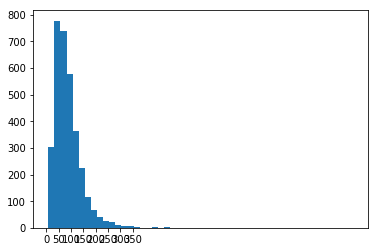

In [19]:
length = []

for t in train_X:
  length.append(len(t))

plt.hist(length, bins = 50)
plt.xticks(range(0, 400, 50))
plt.show()
  

we are using elmo embedding. It is context based word embedding diffrent from glove and word2vec.

In [0]:
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url, trainable=True)


In [0]:
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]


In [26]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu', kernel_regularizer='l2')(embedding)
pred = Dense(2, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 262,914
Trainable params: 262,914
Non-trainable params: 0
_________________________________________________________________


In [28]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(train_text, train_label, validation_data=(val_text, val_label),epochs=150, batch_size=64)
    model.save_weights('./elmo-model.h5')


Train on 3291 samples, validate on 366 samples
Epoch 1/50


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3126d93f60>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


3264/3291 [============================>.] - ETA: 0s - loss: 2.8901 - acc: 0.6547

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3126d936a0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


3291/3291 [==============================] - 21s 6ms/step - loss: 2.8829 - acc: 0.6542 - val_loss: 1.8954 - val_acc: 0.7432
Epoch 2/50
3291/3291 [==============================] - 19s 6ms/step - loss: 1.6001 - acc: 0.7724 - val_loss: 1.3777 - val_acc: 0.7678
Epoch 3/50
3291/3291 [==============================] - 20s 6ms/step - loss: 1.2361 - acc: 0.7894 - val_loss: 1.1318 - val_acc: 0.7869
Epoch 4/50
3291/3291 [==============================] - 20s 6ms/step - loss: 1.0513 - acc: 0.7903 - val_loss: 0.9754 - val_acc: 0.7869
Epoch 5/50
3291/3291 [==============================] - 20s 6ms/step - loss: 0.8990 - acc: 0.8186 - val_loss: 0.8738 - val_acc: 0.7869
Epoch 6/50
3291/3291 [==============================] - 20s 6ms/step - loss: 0.8125 - acc: 0.8204 - val_loss: 0.7931 - val_acc: 0.7978
Epoch 7/50
3291/3291 [==============================] - 21s 6ms/step - loss: 0.7503 - acc: 0.8153 - val_loss: 0.7476 - val_acc: 0.7896
Epoch 8/50
3291/3291 [==============================] - 21s 6ms/st

In [29]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.evaluate(test_text, test_label, batch_size= 32, verbose=1)



Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f3126d52550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


992/992 [==============================] - 11s 11ms/step


The accuracy of our model is 86% in test set.

In [0]:
predicts

[0.338622011604809, 0.8679435483870968]